# Hello World Mobilenet Imagenet

## Imports

In [1]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
base_dir = '/content/drive/MyDrive/dados/HAM10000subset'
base_dir = 'HAM10000/HAM10000subset/'

## Train/test split

In [3]:
classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
dataset_split_percentage = 0.5 # 0.8 # percentage of images for training
IMG_SHAPE = 224

for cl in classes:
    img_path = os.path.join(base_dir, cl)
    images = glob.glob(img_path + '/*.jpg')
    print("{}: {} Images".format(cl, len(images)))
    num_train = int(round(len(images) * dataset_split_percentage))
    train, val = images[:num_train], images[num_train:]

    for t in train:
        if not os.path.exists(os.path.join(base_dir, 'train', cl)):
            os.makedirs(os.path.join(base_dir, 'train', cl))
        bn=os.path.basename(t)
        if not os.path.exists(os.path.join(base_dir, 'train', cl, bn)):
            shutil.move(t, os.path.join(base_dir, 'train', cl))

    for v in val:
        if not os.path.exists(os.path.join(base_dir, 'val', cl)):
            os.makedirs(os.path.join(base_dir, 'val', cl))
        bn = os.path.basename(v)
        if not os.path.exists(os.path.join(base_dir, 'val', cl, bn)):
            shutil.move(v, os.path.join(base_dir, 'val', cl))

print("training images:", round(len(images)*dataset_split_percentage))
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')


akiec: 0 Images
bcc: 0 Images
bkl: 0 Images
df: 0 Images
mel: 0 Images
nv: 0 Images
vasc: 0 Images
training images: 0


In [4]:
batch_size = 16

image_gen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5)
train_data_gen = image_gen_train.flow_from_directory(
    batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_SHAPE,IMG_SHAPE),
    class_mode='sparse')

image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(
    batch_size=batch_size,
    directory=val_dir,
    target_size=(IMG_SHAPE, IMG_SHAPE),
    class_mode='sparse')


Found 350 images belonging to 7 classes.
Found 350 images belonging to 7 classes.


## Load Mobilenet model

In [5]:
model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet')
model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [6]:
model.trainable = False
base_output = model.layers[-2].output # layer number obtained from model summary above
new_output = tf.keras.layers.Dense(7, activation="softmax")(base_output)
modelMobilenetSkin = tf.keras.models.Model(inputs=model.inputs, outputs=new_output)
modelMobilenetSkin.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [7]:
modelMobilenetSkin.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

## Train

In [8]:
epochs = 10
history = modelMobilenetSkin.fit(
    train_data_gen,
    steps_per_epoch=int(np.ceil(train_data_gen.n / float(batch_size))),
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(val_data_gen.n / float(batch_size))) )


Epoch 1/10
22/22 [==============================] - 22s 935ms/step - loss: 2.3149 - accuracy: 0.1859 - val_loss: 1.9108 - val_accuracy: 0.2857
Epoch 2/10
22/22 [==============================] - 18s 820ms/step - loss: 1.7310 - accuracy: 0.3553 - val_loss: 1.7607 - val_accuracy: 0.2886
Epoch 3/10
22/22 [==============================] - 18s 814ms/step - loss: 1.5133 - accuracy: 0.4379 - val_loss: 1.7093 - val_accuracy: 0.3943
Epoch 4/10
22/22 [==============================] - 18s 810ms/step - loss: 1.4212 - accuracy: 0.4771 - val_loss: 1.6381 - val_accuracy: 0.3657
Epoch 5/10
22/22 [==============================] - 18s 819ms/step - loss: 1.3821 - accuracy: 0.5200 - val_loss: 1.5909 - val_accuracy: 0.3886
Epoch 6/10
22/22 [==============================] - 18s 816ms/step - loss: 1.3843 - accuracy: 0.4311 - val_loss: 1.5885 - val_accuracy: 0.4086
Epoch 7/10
22/22 [==============================] - 18s 815ms/step - loss: 1.3569 - accuracy: 0.4736 - val_loss: 1.5557 - val_accuracy: 0.4257

Text(0.5, 1.0, 'Training and Validation Loss')

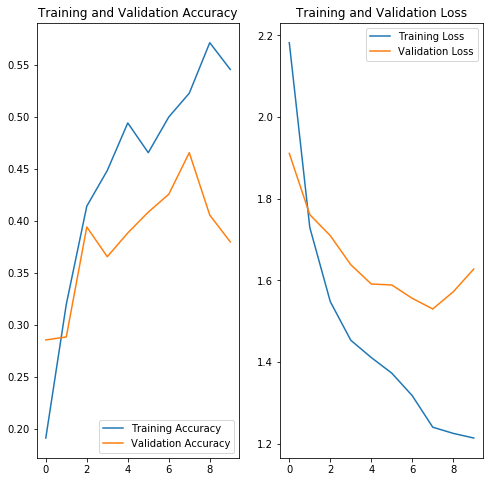

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

## Use the model to predict classes

In [10]:
Y_predict = modelMobilenetSkin.predict(val_data_gen)

In [11]:
Y_predict[0]

array([0.07754503, 0.3272429 , 0.48120037, 0.00555849, 0.10138278,
       0.00336814, 0.00370235], dtype=float32)

In [12]:

Y_predicted_label = np.argmax(Y_predict, axis=-1)
Y_predicted_label

array([2, 2, 1, 5, 1, 6, 6, 5, 2, 2, 5, 2, 1, 4, 2, 5, 5, 4, 1, 1, 0, 6,
       6, 6, 0, 0, 2, 2, 2, 1, 4, 1, 1, 1, 1, 6, 2, 0, 4, 2, 1, 2, 2, 4,
       1, 1, 0, 6, 5, 6, 2, 5, 1, 0, 2, 1, 6, 2, 6, 2, 2, 2, 4, 5, 0, 0,
       5, 4, 3, 4, 2, 2, 2, 2, 1, 6, 1, 6, 6, 5, 2, 2, 2, 4, 2, 4, 4, 4,
       1, 2, 2, 5, 4, 0, 2, 1, 6, 1, 2, 5, 5, 4, 2, 6, 6, 5, 6, 6, 2, 6,
       2, 1, 0, 0, 2, 2, 6, 2, 3, 1, 1, 1, 1, 6, 1, 0, 4, 1, 2, 0, 2, 1,
       4, 6, 1, 1, 4, 1, 2, 6, 6, 1, 0, 2, 6, 5, 2, 1, 4, 0, 1, 2, 0, 2,
       2, 6, 2, 0, 1, 0, 1, 2, 6, 0, 4, 0, 1, 1, 3, 2, 2, 6, 2, 1, 6, 2,
       2, 6, 5, 6, 2, 2, 6, 5, 2, 1, 6, 5, 6, 2, 2, 1, 0, 1, 4, 1, 1, 0,
       6, 1, 6, 0, 4, 2, 2, 0, 6, 2, 0, 0, 2, 2, 6, 2, 4, 3, 5, 1, 2, 4,
       2, 0, 2, 2, 2, 4, 6, 2, 2, 5, 1, 1, 2, 1, 2, 2, 6, 1, 5, 1, 6, 6,
       2, 1, 1, 2, 0, 6, 6, 2, 2, 1, 1, 6, 1, 6, 1, 0, 4, 6, 2, 2, 2, 1,
       2, 1, 2, 5, 5, 4, 6, 0, 1, 6, 5, 4, 2, 2, 2, 0, 1, 1, 2, 1, 2, 1,
       1, 6, 6, 5, 5, 1, 4, 6, 0, 2, 2, 2, 1, 5, 5,

In [14]:
Y_val = np.zeros(350,)
Y_val[50:100]=1
Y_val[100:150]=2
Y_val[150:200]=3
Y_val[200:250]=4
Y_val[250:300]=5
Y_val[300:350]=6
Y_val

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 4., 4., 4., 4.,
       4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4., 4.,
       4., 4., 4., 4., 4.

In [15]:
from sklearn import metrics
cm = metrics.confusion_matrix(Y_val, Y_predicted_label, labels=[0, 1, 2, 3, 4, 5, 6])
print("Confusion Matrix:")
print(cm)

prfs = metrics.precision_recall_fscore_support(Y_val, Y_predicted_label)
print("Precision Recall F-score Support:")
print(prfs)

accuracy = metrics.accuracy_score(Y_val, Y_predicted_label)
print("Accuracy:")
print(accuracy)

cr = metrics.classification_report(Y_val, Y_predicted_label)
print("Classification Report:")
print(cr)

Confusion Matrix:
[[ 5 13 13  0  5  6  8]
 [ 4  7 18  1  8  6  6]
 [ 6 13 11  1  5  3 11]
 [ 7 12 15  1  2  3 10]
 [ 6  8 19  1  4  3  9]
 [ 4 14 14  0  4  6  8]
 [ 5 13 11  1 12  2  6]]
Precision Recall F-score Support:
(array([0.13513514, 0.0875    , 0.10891089, 0.2       , 0.1       ,
       0.20689655, 0.10344828]), array([0.1 , 0.14, 0.22, 0.02, 0.08, 0.12, 0.12]), array([0.11494253, 0.10769231, 0.14569536, 0.03636364, 0.08888889,
       0.15189873, 0.11111111]), array([50, 50, 50, 50, 50, 50, 50], dtype=int64))
Accuracy:
0.11428571428571428
Classification Report:
              precision    recall  f1-score   support

         0.0       0.14      0.10      0.11        50
         1.0       0.09      0.14      0.11        50
         2.0       0.11      0.22      0.15        50
         3.0       0.20      0.02      0.04        50
         4.0       0.10      0.08      0.09        50
         5.0       0.21      0.12      0.15        50
         6.0       0.10      0.12      0.11  